# 滚动式划分训练集
# Rolling train

这是一个动态的训练集，第一折（fold）训练集：t0…t28，验证集t29…t36。这一折训练5个epoche之后，进入第二折，训练集变为t1…t29，验证集则是t30…t0继续训练。Fold2训练5个epoche后，进入第三折，训练集变为t2…t30，验证集则是t31…t1。以此类推，总共训练指定的fold数量。
本意是考虑到数据集是一段可以前后衔接起来的植物生长+衰败的过程，想要让模型学习到所有阶段，但是结果不尽如人意。

This is a dynamic training set. The first fold training set is t0…t28, and the validation set is t29…t36. After training for 5 epochs in this fold, the second fold begins, with the training set becoming t1…t29 and the validation set becoming t30…t0. After training for 5 epochs in Fold2, the third fold begins, with the training set becoming t2…t30 and the validation set becoming t31…t1. This process continues, training for a total of the specified number of folds.

The original intention was to consider that the dataset represents a continuous process of plant growth and decay, aiming for the model to learn all stages. However, the results have been unsatisfactory.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import utils

In [23]:
# 保险：避免 numpy() 报错
tf.config.run_functions_eagerly(True)
try:
    tf.data.experimental.enable_debug_mode()
except Exception:
    pass

SEED = 40
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("eager:", tf.executing_eagerly())



eager: True


In [ ]:
# 读入 (T, y, x, C)
data_arr = utils.load_data("../data/arrays", mask=False)

# 缺失值填 0（跟你原 notebook 一样）
nodataval = 0.0
data_arr = np.where(np.isnan(data_arr), nodataval, data_arr).astype(np.float32)

inputs_all = data_arr                     # (T, y, x, C=9)
outputs_all = data_arr[:, :, :, 0]        # (T, y, x)  取 NDVI 通道

T = inputs_all.shape[0]
H = inputs_all.shape[1]
W = inputs_all.shape[2]
C = inputs_all.shape[3]

print("T,H,W,C =", T, H, W, C)

Loading variables: ['ndvi', 'sm_30cm_mean', 'RAIN_sum', 'irrig_mm_sum', 'IRRAD_sum', 'TMIN_mean', 'TMAX_mean', 'VAP_mean', 'WIND_mean']
ndvi stats:
 - Mean: 0.6202584
 - Std: 0.2126209
 - Min: 0.30207366
 - Max: 0.95584416
sm_30cm_mean stats:
 - Mean: 25.592056
 - Std: 1.9488047
 - Min: 22.266981
 - Max: 28.896538
RAIN_sum stats:
 - Mean: 6.2400007
 - Std: 10.17536
 - Min: 0.0
 - Max: 43.43
irrig_mm_sum stats:
 - Mean: 2.6147704
 - Std: 7.5484
 - Min: 0.0
 - Max: 30.0
IRRAD_sum stats:
 - Mean: 61729.73
 - Std: 14279.029
 - Min: 13110.0
 - Max: 86300.0
TMIN_mean stats:
 - Mean: 12.134594
 - Std: 2.9194298
 - Min: 5.23
 - Max: 17.506666
TMAX_mean stats:
 - Mean: 24.711082
 - Std: 3.9099383
 - Min: 17.663334
 - Max: 34.386665
VAP_mean stats:
 - Mean: 1.4465002
 - Std: 0.28246108
 - Min: 0.88630325
 - Max: 2.046529
WIND_mean stats:
 - Mean: 7.1424327
 - Std: 1.8819456
 - Min: 3.6966667
 - Max: 11.446667
Data loaded with shape: (37, 49, 76, 9)
T,H,W,C = 37 49 76 9


In [3]:
# 可以调（相加不能超过36）
train_len = 28
val_len   = 8

assert train_len + val_len <= T - 1, "需要满足 train_len + val_len <= T-1 (因为要做t->t+1对齐)"

print("train_len =", train_len, "val_len =", val_len, "sum =", train_len + val_len)


train_len = 28 val_len = 8 sum = 36


In [24]:
test_pairs = 6
test_start = np.random.randint(0, T)

test_seq = (test_start + np.arange(test_pairs + 1)) % T
test_in_idx = test_seq[:-1]
test_out_idx = test_seq[1:]

X_test_raw = inputs_all[test_in_idx]                 # (6, H, W, C)
Y_test = outputs_all[test_out_idx][..., None]        # (6, H, W, 1)

print("test_start =", test_start)
print("test_in_idx =", test_in_idx)
print("test_out_idx=", test_out_idx)
print("X_test_raw:", X_test_raw.shape, "Y_test:", Y_test.shape)



test_start = 6
test_in_idx = [ 6  7  8  9 10 11]
test_out_idx= [ 7  8  9 10 11 12]
X_test_raw: (6, 49, 76, 9) Y_test: (6, 49, 76, 1)


In [12]:
def build_cyclic_fold(inputs_all, outputs_all, start, train_len, val_len):
    """
    返回：
      X_train: (train_len, H, W, C)   对应输入 t
      Y_train: (train_len, H, W, 1)   对应标签 t+1
      X_val  : (val_len,   H, W, C)
      Y_val  : (val_len,   H, W, 1)
    全部环状索引，保持时间连续。
    """
    T = inputs_all.shape[0]

    train_seq = (start + np.arange(train_len + 1)) % T
    val_seq   = (start + train_len + np.arange(val_len + 1)) % T

    train_in_idx  = train_seq[:-1]
    train_out_idx = train_seq[1:]

    val_in_idx  = val_seq[:-1]
    val_out_idx = val_seq[1:]

    X_train = inputs_all[train_in_idx]
    Y_train = outputs_all[train_out_idx][..., None]

    X_val = inputs_all[val_in_idx]
    Y_val = outputs_all[val_out_idx][..., None]

    return X_train, Y_train, X_val, Y_val


In [13]:
def normalize_inputs_by_train(X_train, X_val, X_test, eps=1e-6):
    """
    X_*: (time, H, W, C)
    用 train 的均值方差做通道归一化，返回归一化后的 X_*
    """
    # 统计维度：(time, H, W) -> 每个通道一个 mean/std
    mean = np.mean(X_train, axis=(0,1,2), keepdims=True)
    std  = np.std (X_train, axis=(0,1,2), keepdims=True)
    std = np.maximum(std, eps)

    X_train_n = (X_train - mean) / std
    X_val_n   = (X_val   - mean) / std
    X_test_n  = (X_test  - mean) / std
    return X_train_n, X_val_n, X_test_n

In [14]:
# 先用 fold_start=0 的 train 来确定输入shape（不会影响训练本质）
X0_train, Y0_train, X0_val, Y0_val = build_cyclic_fold(inputs_all, outputs_all, start=0, train_len=train_len, val_len=val_len)
X0_train_n, X0_val_n, X0_test_n = normalize_inputs_by_train(X0_train, X0_val, X_test_raw)

model = utils.build_model(X0_train_n)

lr = 2e-4
try:
    optimizer = keras.optimizers.AdamW(learning_rate=lr, weight_decay=1e-4)
except Exception:
    optimizer = keras.optimizers.Adam(learning_rate=lr)

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=optimizer
)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 49, 76,   │             0 │
│                                 │ 9)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_8 (ConvLSTM2D)      │ (None, None, 49, 76,   │        47,360 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)      │ (None, None, 49, 76,   │       221,440 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, None, 49, 76,   │         1,729 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,529 (1.03 MB)

 Trainable params: 270,529 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# 训练调度：每折训少量 epoch
epochs_per_fold = 5
batch_size = 1

# callbacks：只用降学习率，不做 aggressive early stop（避免中途停掉“继续学习”的过程）
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=0
)

n_folds = 20  # 环状滚动一圈
history_log = []

for fold_start in range(n_folds):
    X_train, Y_train, X_val, Y_val = build_cyclic_fold(
        inputs_all, outputs_all, start=fold_start,
        train_len=train_len, val_len=val_len
    )

    X_train_n, X_val_n, X_test_n = normalize_inputs_by_train(X_train, X_val, X_test_raw)

    hist = model.fit(
        np.expand_dims(X_train_n, 0), np.expand_dims(Y_train, 0),
        validation_data=(np.expand_dims(X_val_n, 0), np.expand_dims(Y_val, 0)),
        epochs=epochs_per_fold,
        batch_size=batch_size,
        verbose=0,
        callbacks=[reduce_lr]
    )

    # 记录本折最后一个 epoch 的 loss
    tr_last = float(hist.history["loss"][-1])
    va_last = float(hist.history["val_loss"][-1])

    # 每折都评估同一个 test（观察是否逐步泛化）
    test_loss = float(model.evaluate(np.expand_dims(X_test_n, 0), np.expand_dims(Y_test, 0), verbose=0))

    history_log.append((fold_start, tr_last, va_last, test_loss))

    #if fold_start % 5 == 0:
    print(f"fold {fold_start:02d}: train={tr_last:.4f}  val={va_last:.4f}  test={test_loss:.4f}")

history_log = np.array(history_log, dtype=float)
print("Done. trained 1 model over", n_folds, "rolling folds.")

fold 00: train=0.0298  val=0.0323  test=0.0633
fold 01: train=0.0307  val=0.0389  test=0.0596
fold 02: train=0.0310  val=0.0491  test=0.0579
fold 03: train=0.0308  val=0.0569  test=0.0564
fold 04: train=0.0312  val=0.0607  test=0.0535
fold 05: train=0.0312  val=0.0570  test=0.0508
fold 06: train=0.0327  val=0.0526  test=0.0464
fold 07: train=0.0350  val=0.0517  test=0.0444
fold 08: train=0.0364  val=0.0495  test=0.0442
fold 09: train=0.0383  val=0.0420  test=0.0450
fold 10: train=0.0419  val=0.0394  test=0.0487
fold 11: train=0.0448  val=0.0400  test=0.0487
fold 12: train=0.0488  val=0.0378  test=0.0487
fold 13: train=0.0456  val=0.0379  test=0.0512
fold 14: train=0.0454  val=0.0370  test=0.0508
fold 15: train=0.0440  val=0.0481  test=0.0531
fold 16: train=0.0432  val=0.0598  test=0.0540
fold 17: train=0.0419  val=0.0663  test=0.0552
fold 18: train=0.0408  val=0.0659  test=0.0561
fold 19: train=0.0393  val=0.0751  test=0.0576
Done. trained 1 model over 20 rolling folds.


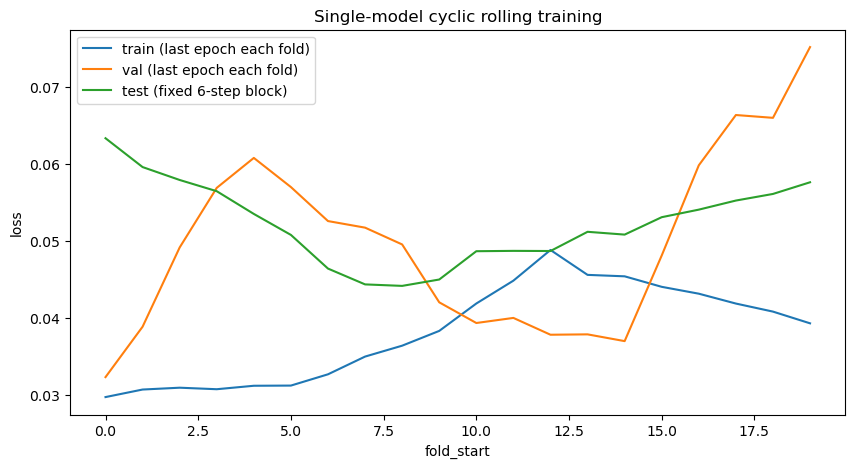

In [36]:
import matplotlib.pyplot as plt

fold_id = history_log[:,0]
train_l = history_log[:,1]
val_l   = history_log[:,2]
test_l  = history_log[:,3]

plt.figure(figsize=(10,5))
plt.plot(fold_id, train_l, label="train (last epoch each fold)")
plt.plot(fold_id, val_l,   label="val (last epoch each fold)")
plt.plot(fold_id, test_l,  label="test (fixed 6-step block)")
plt.xlabel("fold_start")
plt.ylabel("loss")
plt.title("Single-model cyclic rolling training")
plt.legend()
plt.show()


In [33]:
#  取 test 集最后一个时间步的真实 NDVI 图

# 预测：输入需要是 (batch=1, time, H, W, C)
pred_test = model.predict(np.expand_dims(X_test_n, 0), verbose=0)

print("pred_test shape:", pred_test.shape)  # (1, time, H, W, 1)


pred_test shape: (1, 6, 49, 76, 1)


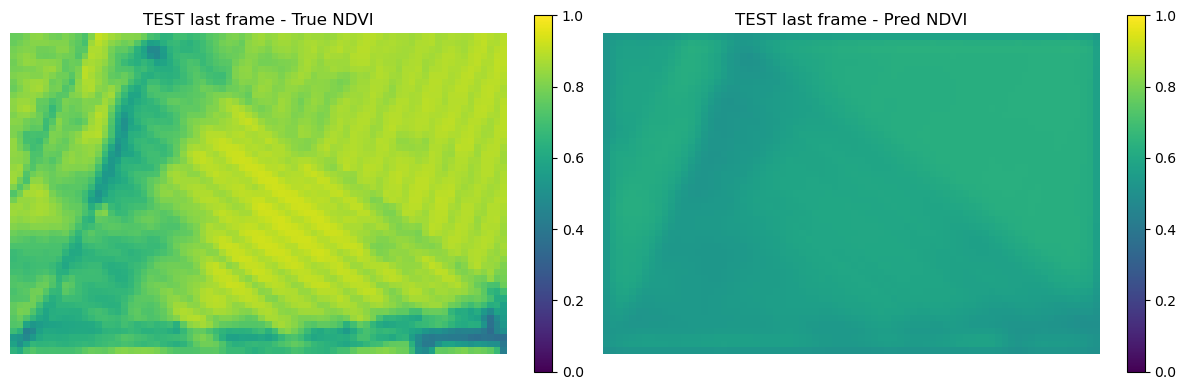

In [34]:

# 最后一帧 index
t_last = Y_test.shape[0] - 1

ndvi_true = Y_test[t_last, :, :, 0]          # (H, W)
ndvi_pred = pred_test[0, t_last, :, :, 0]    # (H, W)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im0 = axes[0].imshow(ndvi_true, vmin=0, vmax=1)
axes[0].set_title("TEST last frame - True NDVI")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(ndvi_pred, vmin=0, vmax=1)
axes[1].set_title("TEST last frame - Pred NDVI")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()
